In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

<ipython-input-4-a644bfe91f28>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X, T, u.T, cmap=cm.coolwarm)


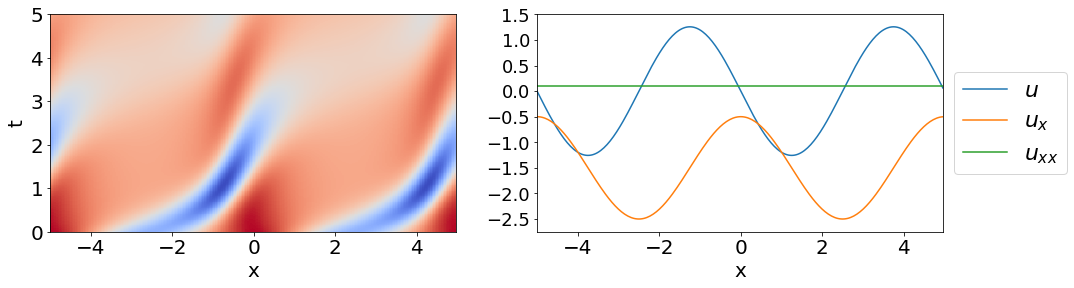

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')

/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [6]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]

In [7]:
xi_true = np.zeros((len(rhs_des),m))
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
xi_true[i_u_x,:] = u_x_true

/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:596: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:566: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


1 u
4 u_{x}
8 u_{xx}
MSE:  0.03990597644658929


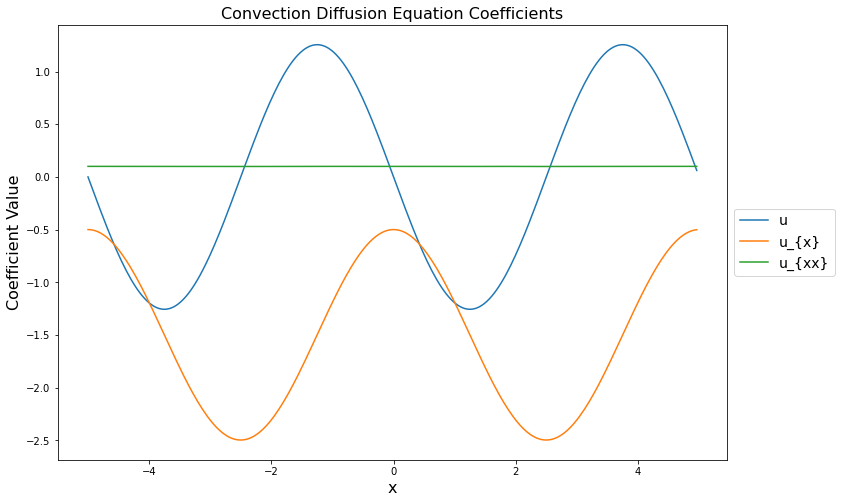

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_sgtr = Norm(xi-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_sgtr)

In [9]:
def error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)
u_pred, u_x_pred, u_xx_pred = xi[1,:], xi[4,:], xi[8,:]
errs = np.array([error(u_pred, u_true), error(u_x_pred, u_x_true), error(u_xx_pred, u_xx_true)])
errs.mean(), errs.std()

(0.2239194298632828, 0.189523818283331)

In [10]:
u, _ = RobustPCA(u, lam_2=0.5)
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]

Please ensure that the shape of U is correct.
iteration:1, err:1470.1390397480393, nc_norm:384.9069633704918 eta1:0.011908266007594169
iteration:50, err:0.0009781982214836448, nc_norm:435.4233060896375 eta1:1.270837729954336
iteration:97, err:8.96936234403775e-06, nc_norm:216.34958766041726 eta1:112.08469195419678


/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [11]:
xi, _, E2 = DLrSR(Theta_grouped, Ut.reshape(X.shape).T, d_tol=30)
def error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)
u_pred, u_x_pred, u_xx_pred = xi[1,:], xi[4,:], xi[8,:]
errs = np.array([error(u_pred, u_true), error(u_x_pred, u_x_true), error(u_xx_pred, u_xx_true)])
errs.mean(), errs.std()

iteration:1, err:2849.0517528368355, nc_norm:867.6439302100312 eta2:0.0066954659256715
iteration:50, err:0.0049730662943040195, nc_norm:488.0302153724775 eta2:50.7763946183502
iteration:100, err:1.2954663392730268e-06, nc_norm:482.00578388064093 eta2:462087.4387043973
iteration:102, err:8.96388510580377e-07, nc_norm:482.00558492505854 eta2:665405.911734332
IALM Finished at iteration 102


/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:596: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:566: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


(0.2351258402876666, 0.2031440752267279)

1 u
4 u_{x}
8 u_{xx}
MSE:  0.0398995125077147


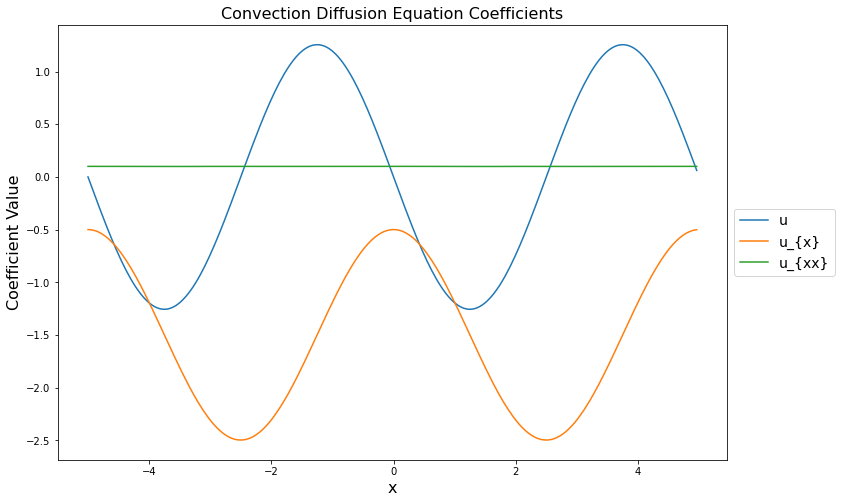

In [12]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_sgtr = Norm(xi-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_sgtr)

In [13]:
# D = Theta_grouped[0].shape[1]
# groups = [[j+D*i for i in range(n)] for j in range(D)]
# Xi_lasso,Lam_lasso,Losses_lasso,History_lasso = TrainGroupLasso(Theta_grouped, Ut_grouped, groups)
# xi_lasso = Xi_lasso[np.argmin(Losses_lasso)]

# pylab.rcParams['figure.figsize'] = (12, 8)
# for j in range(xi_lasso.shape[0]): 
#     if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
#         if rhs_des[j] == '': plot(xi_lasso[j,:], label = '1')
#         else: plot(xi_lasso[j,:], label = rhs_des[j])

# title('Advection Equation Coefficients via Group Lasso', fontsize = 16)
# xlabel('Time', fontsize = 16)
# ylabel('Coefficient Value', fontsize = 16)
# legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

# mse_clean_lasso = Norm(xi_lasso-xi_true)**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_lasso)

In [14]:
# def error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)
# u_pred, u_x_pred, u_xx_pred = xi[1,:], xi[4,:], xi[8,:]
# errs = np.array([error(u_pred, u_true), error(u_x_pred, u_x_true), error(u_xx_pred, u_xx_true)])
# errs.mean(), errs.std()

In [15]:
un = u + 0.01*std(u)*np.random.randn(n,m)

In [16]:
un, _ = RobustPCA(un, lam_2=0.5)

Please ensure that the shape of U is correct.
iteration:1, err:1469.5052361530215, nc_norm:411.5257451395956 eta1:0.011907383695360403
iteration:50, err:0.002399165165990403, nc_norm:450.22789734861124 eta1:1.2707435705128554
iteration:84, err:9.695497633765558e-06, nc_norm:237.2994941716925 eta1:32.46453721856481


In [17]:
# Build linear systems
wx = 10  
wt = 10  

deg_x = 6
deg_t = 4
 
Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [18]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

In [19]:
xi_n, _, _ = DLrSR(Thetan_grouped, Utn.reshape((236, 236)).T, d_tol=50)
def error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)
u_pred, u_x_pred, u_xx_pred = xi_n[1,:], xi_n[4,:], xi_n[8,:]
errs = np.array([error(u_pred, u_true[wt:-wt]), error(u_x_pred, u_x_true[wt:-wt]), error(u_xx_pred, u_xx_true[wt:-wt])])
errs.mean(), errs.std()

iteration:1, err:2405.1678951163626, nc_norm:813.8113193854438 eta2:0.007606200053061036
iteration:50, err:0.07970093219170254, nc_norm:448.62089297542695 eta2:57.683127616187434
iteration:100, err:6.231499336743237e-06, nc_norm:444.8403454473634 eta2:524941.7351697938
iteration:110, err:7.973514064514837e-07, nc_norm:444.83995700403176 eta2:3250300.861288666
IALM Finished at iteration 110


/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:596: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:566: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


(16.60421730927956, 16.892109007249964)

/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:596: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:566: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


MSE:  0.039150628040171734


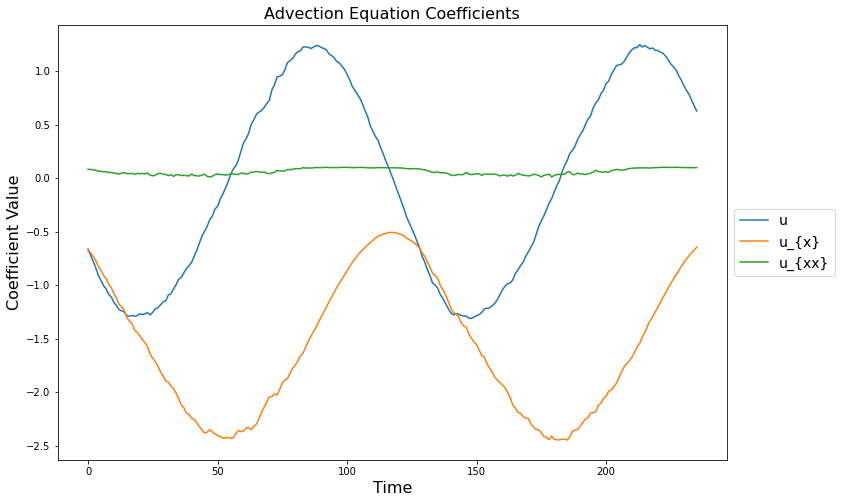

In [19]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Advection Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,wt:-wt])**2/(m*len(rhs_des))
print('MSE: ', mse_noise_sgtr)

In [20]:
def error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)
u_pred, u_x_pred, u_xx_pred = xi_n[1,:], xi_n[4,:], xi_n[8,:]
errs = np.array([error(u_pred, u_true[wt:-wt]), error(u_x_pred, u_x_true[wt:-wt]), error(u_xx_pred, u_xx_true[wt:-wt])])
errs.mean(), errs.std()

(16.519813472261102, 16.838222290203948)

MSE:  0.0391028776242


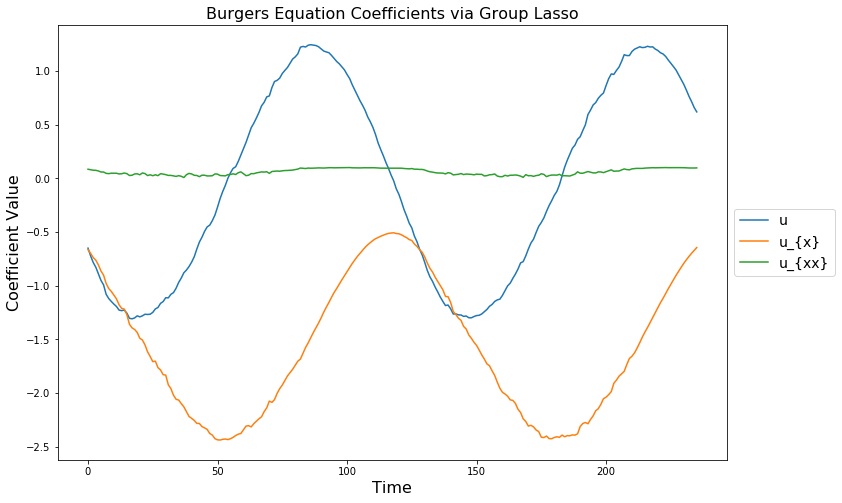

In [15]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n2)] for j in range(D)]
Xi_lasso_n,Lam_lasso_n,Losses_lasso_n,History_lasso_n = TrainGroupLasso(Thetan_grouped, Utn_grouped, groups)
xi_lasso_n = Xi_lasso_n[np.argmin(Losses_lasso_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n.shape[0]): 
    if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        plot(xi_lasso_n[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_lasso = Norm(xi_lasso_n-xi_true[:,wt:-wt])**2/(m*len(rhs_des))
print('MSE: ', mse_noise_lasso)

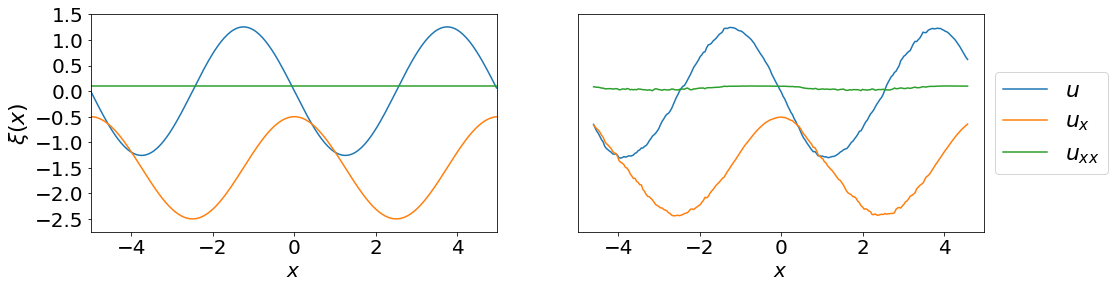

In [16]:
figure(figsize = (16,4))

subplot(1,2,1)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(x,xi[j,:], label = '$'+rhs_des[j]+'$')

ylabel(r'$\xi(x)$', fontsize = fontsize+2)
xlabel(r'$x$', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
ylim(-2.75,1.5)
xlim([x[0],x[-1]])

subplot(1,2,2)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(x[wx:-wx],xi_n[j,:], label = '$'+rhs_des[j]+'$')
        
xticks(fontsize = fontsize)
yticks([])
ylim(-2.75,1.5)
xlabel(r'$x$', fontsize = fontsize)
xlim([x[0],x[-1]])

legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# tight_layout()